## Notes

Parameters to tune:
- type of DL model (e.g. simple rnn, lstm)
- architecture of DL model (e.g. 1-3 layers of rnn, units of rnn)
- params of rnn model: stacking, in/out

Note:
- No padding as we can get the full sequence of 30 observations of every feature since we have all the daily data

Todo's:
- redo train-test-split to become timeseriessplit
- learning rate

Done:
- stacking LSTM's

Questions:
- 27/12/21: when stacking RNNs, 2nd layer RNN results in worse numbers?

## Imports and exporting data

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
import math
import pickle

import requests
import matplotlib.pyplot as plt
import yfinance as yf
import ta
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Normalization, Dense, SimpleRNN, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

In [33]:
#Downloading from yfinance
df=yf.download('AAPL','2017-01-01','2020-12-31')
vix_df = yf.download('^VIX','2017-01-01','2020-12-31')   #for one of the features
#Saving file to jupyter notebook folder
df.to_csv("/Users/ivanlimsweeyong/code/ivanlimsy/jupyter/AAPL.csv")
vix_df.to_csv("/Users/ivanlimsweeyong/code/ivanlimsy/jupyter/VIX.csv")   #for one of the features

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Voting Regressor

In [87]:
df = pd.read_pickle('lstm_result.pickle')

In [88]:
lstm = pd.read_csv("lstm_pred.csv", index_col=0)
lstm.index = pd.to_datetime(lstm.index)
rf = pd.read_csv("rf_random.csv", index_col=0)
rf.index = pd.to_datetime(rf.index)
arima = pd.read_csv("arima.csv", index_col=0)
arima.index = pd.to_datetime(arima.index, dayfirst=True)

In [89]:
lstm.rename(columns={'y_pred_LSTM':'lstm'}, inplace=True)
rf.rename(columns={'RF_pred':'rf'}, inplace=True)
arima.rename(columns={'arima_predicted':'arima'}, inplace=True)

In [90]:
combine = pd.concat([lstm[['lstm']],rf[['rf']],arima[['arima']],df[['actual']]], axis=1, join='outer')

In [91]:
tlength = int(len(combine)*0.8)
X_train = pd.DataFrame(combine.iloc[0:tlength,0:3]); X_test = pd.DataFrame(combine.iloc[tlength:-1,0:3])
y_train = combine.iloc[0:tlength,3]; y_test = combine.iloc[tlength:-1,3]

In [92]:
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

forest = RandomForestRegressor()
linreg = LinearRegression()

In [93]:
ensemble = VotingRegressor(
    estimators=[("rf", forest),("lr", linreg)])
ensemble.fit(X_train, y_train)

VotingRegressor(estimators=[('rf', RandomForestRegressor()),
                            ('lr', LinearRegression())])

In [94]:
results = ensemble.predict(X_test)

In [95]:
ensemble.score(X_test, y_test)

-0.29519140762745466

In [96]:
ensemble_y_pred = pd.DataFrame({'ensemble_y_pred':results})
ensemble_y_test = pd.DataFrame({'ensemble_y_test':y_test})
ensemble_y_test.reset_index(inplace=True, drop=True)

In [ ]:
ensemble_y_test

In [97]:
results_df = ensemble_y_pred.merge(ensemble_y_test,
                       how='inner', left_index=True, right_index=True)

In [100]:
results_df['squared_error'] = (results_df['ensemble_y_pred'] - results_df['ensemble_y_test'])**2
results_df['absolute_error'] = (results_df['ensemble_y_pred'] - results_df['ensemble_y_test']).abs()

In [102]:
print(f"MSE: {results_df['squared_error'].mean()}")
print(f"MAE: {results_df['absolute_error'].mean()}")

MSE: 167.53617642553755
MAE: 10.684197433928011


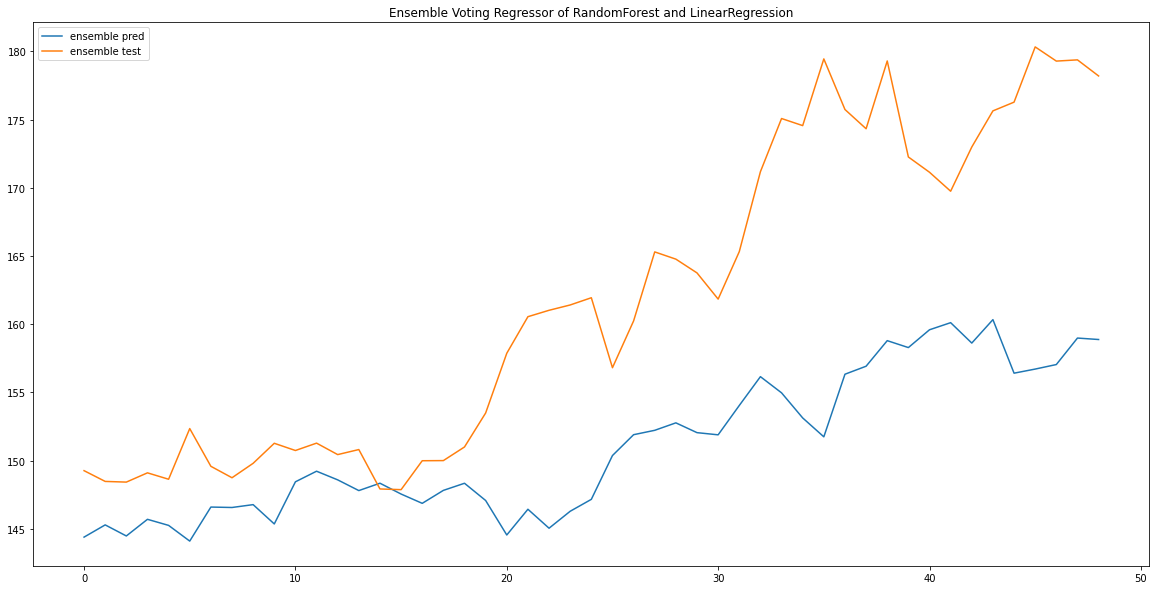

In [103]:
plt.figure(figsize=(20,10))
plt.plot(results_df.index, results_df['ensemble_y_pred'], label='ensemble pred')
plt.plot(results_df.index, results_df['ensemble_y_test'], label='ensemble test')
plt.legend()
plt.title('Ensemble Voting Regressor of RandomForest and LinearRegression')
plt.show()

## Random Forest replication

### Importing data

In [37]:
def load_data(symbol, params):
    start = params['data_start']
    end = params['test_end']
    df = pd.read_csv(f"/Users/ivanlimsweeyong/code/ivanlimsy/jupyter/{symbol}.csv", index_col=0)
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
    if df.index.min()>start or df.index.max()<end:
        start_date = "{0:0=4d}".format(start.year)+'-'+"{0:0=2d}".format(start.month)+'-'+"{0:0=2d}".format(start.day)
        end_date = "{0:0=4d}".format(end.year)+'-'+"{0:0=2d}".format(end.month)+'-'+"{0:0=2d}".format(end.day)
        df = yf.download(f"{symbol}",start_date,end_date)
        df.to_csv(f"{symbol}.csv")
    return df

### Adding indicators

In [38]:
def make_features_target(df, params):
    #Adding indicators
    for days in params['days_list']:
        df[f'w_bol_{days}'] = ta.volatility.BollingerBands(df['Adj Close'], window=days, window_dev=2).bollinger_wband()
        df[f'rsi_{days}'] = ta.momentum.RSIIndicator(df['Adj Close'], window=days).rsi()
        vix_df = load_data("^VIX", params)
        #vix_df = pd.read_csv("/Users/ivanlimsweeyong/code/ivanlimsy/jupyter/VIX.csv", index_col=0)
        #vix_df.index = pd.to_datetime(vix_df.index, format='%Y-%m-%d')
        vix_df.rename(columns={'Adj Close': 'vix_adj_close'}, inplace=True)
        df = df.merge(vix_df[['vix_adj_close']], left_index=True, right_index=True)
        df[f'ma_{days}'] = ta.trend.SMAIndicator(df['Adj Close'], window=days).sma_indicator()
    #df['macd'] = ta.trend.MACD(df['Adj Close'], window_slow=26, window_fast=12, window_sign=9).macd()
    #df['roc'] = ta.momentum.ROCIndicator(df['Adj Close'], window=30).roc()
    #df['cci'] = ta.trend.CCIIndicator(df['High'], df['Low'], df['Adj Close'], window=30, constant=0.015).cci()
    #df['atr'] = ta.volatility.AverageTrueRange(df['High'], df['Low'], df['Adj Close'], window=30).average_true_range()
    #df['fast_stocOc'] = ta.momentum.StochasticOscillator(df['High'], df['Low'], df['Adj Close'], window=14, smooth_window=1).stoch()
    #df['slow_stocOc'] = ta.momentum.StochasticOscillator(df['High'], df['Low'], df['Adj Close'], window=14, smooth_window=3).stoch()
    #df['obv'] = ta.volume.OnBalanceVolumeIndicator(df['Adj Close'], df['Volume']).on_balance_volume()
    #Adding target
    df['target'] = df['Adj Close'].shift(periods=-(params['fut_days']))
    #Dropping irrelevant columns, dropping null rows, and trimming by time period
    df.drop(labels=['Open', 'High', 'Low', 'Close'], axis=1, inplace=True)
    df.dropna(axis=0, inplace=True)
    df = df[df.index>=params['train_start']]
    df = df[df.index<=params['test_end']]
    return df
#Following brendan's features
# def make_features_target(df, params):
#     #Adding indicators
#     for n in [14,30,50,200]:
#         df[f"w_bol_{n}"] = ta.volatility.BollingerBands(df['Adj Close'], window=n, window_dev=2).bollinger_wband()
#         df[f"rsi_{n}"] = ta.momentum.RSIIndicator(df['Adj Close'], window=n).rsi()
#         df[f"ma_{n}"] = ta.trend.SMAIndicator(df['Adj Close'], window=n).sma_indicator()
#     #Adding target
#     df['target'] = df['Adj Close'].shift(periods=-(params['fut_days']))
#     #Dropping irrelevant columns, dropping null rows, and trimming by time period
#     df.drop(labels=['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
#     df.dropna(axis=0, inplace=True)
#     df = df[df.index>=params['time_start']]
#     df = df[df.index<=params['time_end']]
#     return df

### Transform X and Y (changed to random forest structure instead of RNN structure)

In [46]:
#slicing [a,b]: loc includes both a & b, while iloc includes a excludes b
def transform_data(df, params):
    X = df.drop(labels='target', axis=1).copy()
    y = df[['target']].copy()
    #Setting X_test and y_test
    #trainval_length = int(len(df)*(1-params['test_size']))
    X_trainval_df = X[X.index<params['test_start']]
    y_trainval_df = y[y.index<params['test_start']]
    #X_trainval_df = X.iloc[0:trainval_length,:]
    #y_trainval_df = y.iloc[0:trainval_length,:]    
    X_test_df = X[X.index>=params['test_start']]
    y_test_df = y[y.index>=params['test_start']]
    #X_test_df = X.iloc[trainval_length:-1,:]
    #y_test_df = y.iloc[trainval_length:-1,:]
    
    #Setting X_train/X_val, and y_train/y_val
    #train_length = int(len(X_trainval_df)*(1-params['val_size']))
    X_train_df = X_trainval_df[X_trainval_df.index<params['val_start']]
    y_train_df = y_trainval_df[y_trainval_df.index<params['val_start']]
    #X_train_df = X_trainval_df.iloc[0:train_length,:]
    #y_train_df = y_trainval_df.iloc[0:train_length,:]
    X_val_df = X_trainval_df[X_trainval_df.index>=params['val_start']]
    y_val_df = y_trainval_df[y_trainval_df.index>=params['val_start']]
    #X_val_df = X_trainval_df.iloc[train_length:-1,:]
    #y_val_df = y_trainval_df.iloc[train_length:-1,:]
    
    #Scaling X features
    scaler = StandardScaler()
    X_train_df = pd.DataFrame(scaler.fit_transform(X_train_df))
    scaler = StandardScaler()
    X_val_df = pd.DataFrame(scaler.fit_transform(X_val_df))
    scaler = StandardScaler()
    X_test_df = pd.DataFrame(scaler.fit_transform(X_test_df))
    
    #Shapes: (n_sequences, n_observations, n_features)
#     print(f"Train shapes: X is {X_train.shape} and y is {y_train.shape}")
#     print(f"Val shapes: X is {X_val.shape} and y is {y_val.shape}")
#     print(f"Test shapes: X is {X_test.shape} and y is {y_test.shape}")
#     print(f"Total number of sequences reduced from {len(df)} to {X_train.shape[0]+X_test.shape[0]}")
    return X_train_df, X_val_df, X_test_df, y_train_df, y_val_df, y_test_df

### Sampling time series split

In [388]:
params={
    'hist_days':60, 'fut_days':3,
    'data_start': dt.datetime(2017,1,1,0,0,0),
    'train_start':dt.datetime(2018,1,1,0,0,0), 'train_end':dt.datetime(2020,3,31,23,59,59),
    'val_start':dt.datetime(2020,4,1,0,0,0), 'val_end':dt.datetime(2020,12,31,23,59,59),
    'test_start':dt.datetime(2021,1,1,0,0,0), 'test_end':dt.datetime(2021,12,31,23,59,59),
    'days_list':[14,50,200], #'bol_days':30, 'rsi_days':14, 'ma_days': 30,
    'val_size': 0.2, 'test_size':0.15, 'batch_size':2, 'epochs':20,
    'loss':'mse', 'optimizer':'rmsprop', 'metrics':'mae', 'patience':10,
    'train_loss': np.nan, 'val_loss':np.nan, 'test_loss':np.nan, 'test_metric':np.nan,
    'last_px':np.nan, 'remarks':''
    }
df = load_data("MMM", params)
df = make_features_target(df, params)
print(df.iloc[-1,0])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
176.6999969482422


In [316]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate

In [389]:
X = df.drop('target', axis=1).copy()
y = df['target']
length = int(len(X)*0.8)
X_train = X.iloc[:length,:]; X_test = X.iloc[length:,:]
y_train = y[:length]; y_test = y[length:]

### DecisionTreeRegressor

#### Method 1 for obtaining cv value for cross-validate
- using TimeSeriesSplit().split(X)
- which returns a generator object, an acceptable input for cross_validate
- however, there is no gap between train and test, i.e.
   - y_train crosses over to X_test, and
   - X_test overlaps with X_train (5-200 days), though I'm not sure if this is an issue

In [395]:
tree = DecisionTreeRegressor()
train = TimeSeriesSplit().split(X_train)
cv_results=cross_validate(tree, X_train, y_train, scoring="neg_mean_squared_error", cv=train)
abs(cv_results['test_score'].min())**0.5

32.79991374060427

#### Method 2 for obtaining cv value for cross-validate (can't create iterable)
- using TimeSeriesSplit().split(X), but formatting into iterable
- which is also an acceptable input for cross_validate
- here, it's possible to manually leave out the last 5 entries of each train's fold if we don't want it to overlap into the test's fold
- again, I'm not sure if it's important to ensure no overlaps for the time period covered by the indicators themselves from X_test into y_train (Adj close is also a feature, and most indicators are derived from Adj Close anyway

In [292]:
counter=0
train=[]; test=[]; train_test = []
for train_index, test_index in TimeSeriesSplit().split(X):
    train = np.array(train_index)
    test = np.array(test_index)
    train_test.append(zip(train, test))
#     train.append(train_index)
#     test.append(test_index)
#     print(type(train_index))
#     print(type(test_index))
# train = iter(train); test = iter(test)
# train=np.array(train, dtype='object')
# test=np.array(test, dtype='object')
# train_test = zip(train,test)
train_test = np.array(train_test)

In [289]:
train

array([array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
               13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
               26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
               39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
               52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
               65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
               78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
               91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
              104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
              117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
              130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
              143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
              156, 157, 158, 159, 160, 161, 162, 163

In [286]:
print(len(train_test))
print(train_test[0].shape)

2
(5,)


In [293]:
test[0].shape

()

In [294]:
cv_results=cross_validate(tree, X, y, scoring="neg_mean_squared_error", cv=train_test)

ValueError: too many values to unpack (expected 2)

In [122]:
cv_results

{'fit_time': array([0.00486183, 0.00704789, 0.00699711, 0.00966787, 0.0116899 ]),
 'score_time': array([0.00325203, 0.00311923, 0.00198865, 0.00176501, 0.00226212]),
 'test_score': array([ -62.43688879, -100.42813538, -377.84784372, -103.62815956,
        -337.08008449])}

In [102]:
type(train)

generator

In [103]:
z=[1,2,3]
type(z)

list

In [106]:
asd = iter(np.array(z))
type(asd)

iterator

In [100]:
# print(train[0])
counter = 0
for i in train:
    counter+=1; print(counter)
    print(i)

1
(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168]), array([169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 17

In [68]:
train_indices = []
test_indices = []
time_series_split = TimeSeriesSplit()
for i, j in time_series_split.split(np.array(X)):
    train_indices.append(i)
    test_indices.append(j)

In [87]:
time_series_split.split(np.array(X))

<generator object TimeSeriesSplit.split at 0x11ac87b30>

In [77]:
X_train = []
y_train = []
for i in train_indices:
    X_train.append(X.iloc[:i[-1],:])
    y_train.append(y[:i[-1]])

In [67]:
169+167

336

### RandomForest

In [376]:
from sklearn.ensemble import RandomForestRegressor

In [398]:
forest = RandomForestRegressor(n_estimators=100)
train = TimeSeriesSplit().split(X_train)
cv_results = cross_validate(forest, X_train, y_train,
                            scoring = "neg_mean_squared_error", cv=train)
abs(cv_results['test_score'].min())**0.5

27.093241838166715

In [ ]:
tree = DecisionTreeRegressor()
train = TimeSeriesSplit().split(X_train)
cv_results=cross_validate(tree, X_train, y_train, scoring="neg_mean_squared_error", cv=train)
abs(cv_results['test_score'].min())**0.5

### Fitting random forest onto X_train and X_val

In [47]:
params={
    'hist_days':60, 'fut_days':3,
    'data_start': dt.datetime(2017,1,1,0,0,0),
    'train_start':dt.datetime(2018,1,1,0,0,0), 'train_end':dt.datetime(2020,3,31,23,59,59),
    'val_start':dt.datetime(2020,4,1,0,0,0), 'val_end':dt.datetime(2020,12,31,23,59,59),
    'test_start':dt.datetime(2021,1,1,0,0,0), 'test_end':dt.datetime(2021,12,31,23,59,59),
    'days_list':[14,50,200], #'bol_days':30, 'rsi_days':14, 'ma_days': 30,
    'val_size': 0.2, 'test_size':0.15, 'batch_size':2, 'epochs':20,
    'loss':'mse', 'optimizer':'rmsprop', 'metrics':'mae', 'patience':10,
    'train_loss': np.nan, 'val_loss':np.nan, 'test_loss':np.nan, 'test_metric':np.nan,
    'last_px':np.nan, 'remarks':''
    }
df = load_data("AAPL", params)
df = make_features_target(df, params)
params['last_px']=df.iloc[-1,:]['Adj Close']
X_train_df, X_val_df, X_test_df, y_train_df, y_val_df, y_test_df = transform_data(df, params)
# model = initialize_model(params)
# model, history = run_model(X_train, y_train, X_val, y_val, model, params)
# results = evaluate_model(X_test, y_test, model)
# params['train_loss'] = round(history.history['loss'][-1],4)
# params['val_loss'] = round(history.history['val_loss'][-1], 4)
# params['test_loss'] = round(results[0], 4)
# params['test_metric'] = round(results[1], 4)
# params['remarks'] = 'RNN(50,tanh), Dense(15,linear), Dense(1,linear)'
#KIV: dropouts, regularization (DL lecture 2)
#No. of params for RNN layer: units*(units+features+1bias)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [51]:
y_train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 565 entries, 2018-01-02 to 2020-03-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  565 non-null    float64
dtypes: float64(1)
memory usage: 8.8 KB


In [52]:
y_val_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 191 entries, 2020-04-01 to 2020-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  191 non-null    float64
dtypes: float64(1)
memory usage: 3.0 KB


In [53]:
y_test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248 entries, 2021-01-04 to 2021-12-27
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  248 non-null    float64
dtypes: float64(1)
memory usage: 3.9 KB


### Next

### Next

### Next

## LSTM - functionalized

### Functions

#### Importing data

In [32]:
symbol = 'AAPL'
start = params['train_start']
end = params['test_end']
start_date = "{0:0=4d}".format(start.year)+'-'+"{0:0=2d}".format(start.month)+'-'+"{0:0=2d}".format(start.day)
end_date = "{0:0=4d}".format(end.year)+'-'+"{0:0=2d}".format(end.month)+'-'+"{0:0=2d}".format(end.day)
df = yf.download(f"{symbol}",start_date,end_date)
df.to_csv(f"{symbol}.csv")


[*********************100%***********************]  1 of 1 completed


In [33]:
def load_data(symbol, params):
    start = params['data_start']
    end = params['test_end']
    df = pd.read_csv(f"/Users/ivanlimsweeyong/code/ivanlimsy/jupyter/{symbol}.csv", index_col=0)
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
    if df.index.min()>start or df.index.max()<end:
        start_date = "{0:0=4d}".format(start.year)+'-'+"{0:0=2d}".format(start.month)+'-'+"{0:0=2d}".format(start.day)
        end_date = "{0:0=4d}".format(end.year)+'-'+"{0:0=2d}".format(end.month)+'-'+"{0:0=2d}".format(end.day)
        df = yf.download(f"{symbol}",start_date,end_date)
        df.to_csv(f"{symbol}.csv")
    return df

#### Adding indicators

In [34]:
def make_features_target(df, params):
    #Adding indicators
    for days in params['days_list']:
        df[f'w_bol_{days}'] = ta.volatility.BollingerBands(df['Adj Close'], window=days, window_dev=2).bollinger_wband()
        df[f'rsi_{days}'] = ta.momentum.RSIIndicator(df['Adj Close'], window=days).rsi()
        
        df[f'ma_{days}'] = ta.trend.SMAIndicator(df['Adj Close'], window=days).sma_indicator()
    vix_df = load_data("^VIX", params)
    #vix_df = pd.read_csv("/Users/ivanlimsweeyong/code/ivanlimsy/jupyter/VIX.csv", index_col=0)
    #vix_df.index = pd.to_datetime(vix_df.index, format='%Y-%m-%d')
    vix_df.rename(columns={'Adj Close': 'vix_adj_close'}, inplace=True)
    df = df.merge(vix_df[['vix_adj_close']], left_index=True, right_index=True)

    #df['macd'] = ta.trend.MACD(df['Adj Close'], window_slow=26, window_fast=12, window_sign=9).macd()
    #df['roc'] = ta.momentum.ROCIndicator(df['Adj Close'], window=30).roc()
    #df['cci'] = ta.trend.CCIIndicator(df['High'], df['Low'], df['Adj Close'], window=30, constant=0.015).cci()
    #df['atr'] = ta.volatility.AverageTrueRange(df['High'], df['Low'], df['Adj Close'], window=30).average_true_range()
    #df['fast_stocOc'] = ta.momentum.StochasticOscillator(df['High'], df['Low'], df['Adj Close'], window=14, smooth_window=1).stoch()
    #df['slow_stocOc'] = ta.momentum.StochasticOscillator(df['High'], df['Low'], df['Adj Close'], window=14, smooth_window=3).stoch()
    #df['obv'] = ta.volume.OnBalanceVolumeIndicator(df['Adj Close'], df['Volume']).on_balance_volume()
    #Adding target
    df['target'] = df['Adj Close'].shift(periods=-(params['fut_days']))
    #Dropping irrelevant columns, dropping null rows, and trimming by time period
    df.drop(labels=['Open', 'High', 'Low', 'Close'], axis=1, inplace=True)
    df.dropna(axis=0, inplace=True)
    df = df[df.index>=params['train_start']]
    df = df[df.index<=params['test_end']]
    return df
#Following brendan's features
# def make_features_target(df, params):
#     #Adding indicators
#     for n in [14,30,50,200]:
#         df[f"w_bol_{n}"] = ta.volatility.BollingerBands(df['Adj Close'], window=n, window_dev=2).bollinger_wband()
#         df[f"rsi_{n}"] = ta.momentum.RSIIndicator(df['Adj Close'], window=n).rsi()
#         df[f"ma_{n}"] = ta.trend.SMAIndicator(df['Adj Close'], window=n).sma_indicator()
#     #Adding target
#     df['target'] = df['Adj Close'].shift(periods=-(params['fut_days']))
#     #Dropping irrelevant columns, dropping null rows, and trimming by time period
#     df.drop(labels=['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
#     df.dropna(axis=0, inplace=True)
#     df = df[df.index>=params['time_start']]
#     df = df[df.index<=params['time_end']]
#     return df

#### Transform data into X and y

In [35]:
#slicing [a,b]: loc includes both a & b, while iloc includes a excludes b
def transform_data(df, params):
    X = df.drop(labels='target', axis=1).copy()
    y = df[['target']].copy()
    #Setting X_test and y_test
    #trainval_length = int(len(df)*(1-params['test_size']))
    X_trainval_df = X[X.index<params['test_start']]
    y_trainval_df = y[y.index<params['test_start']]
    #X_trainval_df = X.iloc[0:trainval_length,:]
    #y_trainval_df = y.iloc[0:trainval_length,:]    
    X_test_df = X[X.index>=params['test_start']]
    y_test_df = y[y.index>=params['test_start']]
    #X_test_df = X.iloc[trainval_length:-1,:]
    #y_test_df = y.iloc[trainval_length:-1,:]
    
    #Setting X_train/X_val, and y_train/y_val
    #train_length = int(len(X_trainval_df)*(1-params['val_size']))
    X_train_df = X_trainval_df[X_trainval_df.index<params['val_start']]
    y_train_df = y_trainval_df[y_trainval_df.index<params['val_start']]
    #X_train_df = X_trainval_df.iloc[0:train_length,:]
    #y_train_df = y_trainval_df.iloc[0:train_length,:]
    X_val_df = X_trainval_df[X_trainval_df.index>=params['val_start']]
    y_val_df = y_trainval_df[y_trainval_df.index>=params['val_start']]
    #X_val_df = X_trainval_df.iloc[train_length:-1,:]
    #y_val_df = y_trainval_df.iloc[train_length:-1,:]
    
    #Scaling X features
    scaler = StandardScaler()
    X_train_df = pd.DataFrame(scaler.fit_transform(X_train_df))
    scaler = StandardScaler()
    X_val_df = pd.DataFrame(scaler.fit_transform(X_val_df))
    scaler = StandardScaler()
    X_test_df = pd.DataFrame(scaler.fit_transform(X_test_df))
    
    #E.g.100 observations, index 0 to 99
    #Historical days: 30 including the day itself
    #Future days: 5
    #Total days: 1-100 >> 0-99 >> iloc/range(0:100)
        #1st i: 30 >> iloc/range(29)
        #1st historical days: 1-30 >> 0:29 >> iloc/range(0:30)
        #1st future days: 31:35 >> 30:34 >> iloc/range(30,35)
        #Last i: 95 >> iloc/range(94)
        #Last historical days: 66:95 >> 65:94 >> iloc/range(65:95)
        #Last future days: 96:100 >> 95:99 >> iloc/range(95:100)
    
    #Preparing sequences of features for X_train and targets for y_train
    X_train = []
    y_train = []
    #(30-1):(100-5-1) >> 29:94
    for i in range((params['hist_days']-1),(len(X_train_df)-1)):
        #(29-30+1):(29+1) >> 0:30
        X_train.append(np.array(X_train_df.iloc[(i-params['hist_days']+1):i+1,:]))
        #(29+5):0 >> 34:0
        y_train.append(np.array(y_train_df.iloc[i,0]))
    
    #Preparing sequences of features for X_val and targets for y_val
    X_val = []
    y_val = []
    for i in range((params['hist_days']-1),(len(X_val_df)-1)):
        X_val.append(np.array(X_val_df.iloc[(i-params['hist_days']+1):i+1,:]))
        y_val.append(np.array(y_val_df.iloc[i,0]))
    
    #Preparing sequences of features for X_test and targets for y_test
    X_test = []
    y_test = []
    for i in range((params['hist_days']-1),(len(X_test_df)-1)):
        X_test.append(np.array(X_test_df.iloc[(i-params['hist_days']+1):i+1,:]))
        y_test.append(np.array(y_test_df.iloc[i, 0]))
    
    X_train = np.array(X_train); y_train = np.array(y_train);
    y_train = np.reshape(np.array([y_train]),(y_train.shape[0],1))
    X_val = np.array(X_val); y_val = np.array(y_val)
    y_val = np.reshape(np.array([y_val]),(y_val.shape[0],1))
    X_test = np.array(X_test); y_test = np.array(y_test)
    y_test = np.reshape(np.array([y_test]),(y_test.shape[0],1))
    
    #Shapes: (n_sequences, n_observations, n_features)
    print(f"Train shapes: X is {X_train.shape} and y is {y_train.shape}")
    print(f"Val shapes: X is {X_val.shape} and y is {y_val.shape}")
    print(f"Test shapes: X is {X_test.shape} and y is {y_test.shape}")
    print(f"Total number of sequences reduced from {len(df)} to {X_train.shape[0]+X_test.shape[0]}")
    return X_train, X_val, X_test, y_train, y_val, y_test, X_train_df, X_val_df, X_test_df

#### Initializing and fitting model:

In [36]:
# reg_11 = regularizers.L1(0.01)

def initialize_model(params):
    reg_l1 = regularizers.L1(0.01)
    model=Sequential()
#     model.add(Normalization())
    model.add(LSTM(20, activation='tanh', return_sequences=True, kernel_regularizer=reg_l1))
    model.add(LSTM(20, activation='tanh'))
    model.add(Dense(15,activation="linear"))
    model.add(Dense(1,activation="linear"))
    model.compile(loss=params['loss'], optimizer=params['optimizer'], metrics=params['metrics'])
    return model

In [48]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 20)            2800      
                                                                 
 dense_8 (Dense)             (None, 30, 15)            315       
                                                                 
 dense_9 (Dense)             (None, 30, 1)             16        
                                                                 
Total params: 3,131
Trainable params: 3,131
Non-trainable params: 0
_________________________________________________________________


In [37]:
def run_model(X_train, y_train, X_val, y_val, model, params):
    model = model
    es = EarlyStopping(patience=params['patience'])
    history = model.fit(X_train, y_train,
                        batch_size=params['batch_size'], verbose=1, callbacks=es,
                        validation_data=(X_val, y_val), epochs= params['epochs'])
    return model, history

In [38]:
def evaluate_model(X_test, y_test, model):
    return model.evaluate(X_test, y_test)

#### Creating/Adding/Reading summary of analyses

In [8]:
#Creating dataframe to save as csv for the first time
def create_analysis():
    summary = pd.DataFrame(params, index=[0])
    summary.to_csv('summary_v02.csv')
#Store results and save as csv
def add_analysis():
    summary = pd.read_csv('summary_v02.csv', index_col=0)
    summary['time_start'] = pd.to_datetime(summary['time_start'], format="%Y-%m-%dT%H:%M:%S")
    summary['time_end'] = pd.to_datetime(summary['time_end'], format="%Y-%m-%dT%H:%M:%S")
    addon = pd.DataFrame(params, index=[0])
    summary = pd.concat([summary, addon], axis=0, join='outer', ignore_index=True)
    summary.index = np.array([0]*len(summary))
    summary.drop_duplicates(inplace=True, ignore_index=True)
    summary.to_csv('summary_v02.csv')
def read_analysis():
    summary = pd.read_csv('summary_v02.csv', index_col=0)
    summary['time_start'] = pd.to_datetime(summary['time_start'], format="%Y-%m-%dT%H:%M:%S")
    summary['time_end'] = pd.to_datetime(summary['time_end'], format="%Y-%m-%dT%H:%M:%S")
    return summary

### Running all functions

load_data() >> add_indicators(df, params) >> transform_data(df, params) >> <br>
initialize_model(params) >> run_model(X_train, y_train, model, params) >> evaluate_model(X_test, y_test, model, params)

In [39]:
params={
    'hist_days':30, 'fut_days':5,
    'data_start': dt.datetime(2017,1,1,0,0,0),
    'train_start':dt.datetime(2018,1,1,0,0,0), 'train_end':dt.datetime(2020,3,31,23,59,59),
    'val_start':dt.datetime(2020,4,1,0,0,0), 'val_end':dt.datetime(2020,12,31,23,59,59),
    'test_start':dt.datetime(2021,1,1,0,0,0), 'test_end':dt.datetime(2021,12,31,23,59,59),
    'days_list':[14,50,200], #'bol_days':30, 'rsi_days':14, 'ma_days': 30,
    'val_size': 0.2, 'test_size':0.15, 'batch_size':2, 'epochs':20,
    'loss':'mse', 'optimizer':'rmsprop', 'metrics':'mae', 'patience':10,
    'train_loss': np.nan, 'val_loss':np.nan, 'test_loss':np.nan, 'test_metric':np.nan,
    'last_px':np.nan, 'remarks':''
    }
df = load_data("AAPL", params)
df = make_features_target(df, params)
params['last_px']=df.iloc[-1,:]['Adj Close']
X_train, X_val, X_test, y_train, y_val, y_test, X_train_df, X_val_df, X_test_df = transform_data(df, params)
model = initialize_model(params)
model, history = run_model(X_train, y_train, X_val, y_val, model, params)
results = evaluate_model(X_test, y_test, model)
params['train_loss'] = round(history.history['loss'][-1],4)
params['val_loss'] = round(history.history['val_loss'][-1], 4)
params['test_loss'] = round(results[0], 4)
params['test_metric'] = round(results[1], 4)
params['remarks'] = 'RNN(50,tanh), Dense(15,linear), Dense(1,linear)'
#KIV: dropouts, regularization (DL lecture 2)
#No. of params for RNN layer: units*(units+features+1bias)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Train shapes: X is (535, 30, 12) and y is (535, 1)
Val shapes: X is (161, 30, 12) and y is (161, 1)
Test shapes: X is (216, 30, 12) and y is (216, 1)
Total number of sequences reduced from 1002 to 751
Epoch 1/20
268/268 [==============================] - 16s 33ms/step - loss: 1237.9193 - mae: 30.6709 - val_loss: 4082.2617 - val_mae: 62.0038
Epoch 2/20
268/268 [==============================] - 7s 25ms/step - loss: 116.4524 - mae: 7.9036 - val_loss: 3267.9783 - val_mae: 55.9510
Epoch 3/20
268/268 [==============================] - 8s 29ms/step - loss: 23.9616 - mae: 3.1942 - val_loss: 3281.9197 - val_mae: 56.6667
Epoch 4/20
268/268 [==============================] - 7s 27ms/step - loss: 8.6433 - mae: 2.0588 - val_loss: 3372.6975 - val_mae: 57.4342
Epoch 5/20
268/268 [==============================] - 7s 25ms/step - loss: 6.5986 - mae: 1.7690 - val_los

val: 57 test: 88
regularize: val: 58 test: 88

In [84]:
#create_analysis(), add_analysis(), read_analysis()
# create_analysis()
add_analysis()
# read_analysis()

In [85]:
read_analysis()

,hist_days,fut_days,time_start,time_end,bol_days,rsi_days,ma_days,val_size,test_size,batch_size,...,loss,optimizer,metrics,patience,train_loss,val_loss,test_loss,test_metric,last_px,remarks
0,30,5,2017-09-01,2020-12-31,30,30,30,0.2,0.2,4,...,mae,rmsprop,mae,10,0.8345,22.9410,55.3683,55.3683,131.071976,"LSTM(20,tanh), LSTM(20,tanh), Dense(15,linear)..."
1,30,5,2017-09-01,2020-12-31,30,30,30,0.2,0.2,2,...,mae,rmsprop,mae,10,1.4083,23.2593,55.4531,55.4531,131.071976,"RNN(50,tanh), Dense(15,linear), Dense(1,linear)"
2,30,2,2017-09-01,2020-12-31,30,30,30,0.2,0.2,2,...,mae,rmsprop,mae,10,1.4166,24.0199,56.4973,56.4973,135.852509,"RNN(50,tanh), Dense(15,linear), Dense(1,linear)"


## LSTM - training in train+val data, predicting for test data (4/1/21 to 23/12/21), saving df as pickle and model as joblib

### Storing as dataframe

In [3]:
def load_data(symbol, params):
    start = params['data_start']
    end = params['test_end']
    df = pd.read_csv(f"/Users/ivanlimsweeyong/code/ivanlimsy/jupyter/{symbol}.csv", index_col=0)
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
    if df.index.min()>start or df.index.max()<end:
        start_date = "{0:0=4d}".format(start.year)+'-'+"{0:0=2d}".format(start.month)+'-'+"{0:0=2d}".format(start.day)
        end_date = "{0:0=4d}".format(end.year)+'-'+"{0:0=2d}".format(end.month)+'-'+"{0:0=2d}".format(end.day)
        df = yf.download(f"{symbol}",start_date,end_date)
        df.to_csv(f"{symbol}.csv")
    return df

In [4]:
def make_features_target(df, params):
    #Adding indicators
    for days in params['days_list']:
        df[f'w_bol_{days}'] = ta.volatility.BollingerBands(df['Adj Close'], window=days, window_dev=2).bollinger_wband()
        df[f'rsi_{days}'] = ta.momentum.RSIIndicator(df['Adj Close'], window=days).rsi()
        df[f'ma_{days}'] = ta.trend.SMAIndicator(df['Adj Close'], window=days).sma_indicator()
    vix_df = load_data("^VIX", params)
    vix_df.rename(columns={'Adj Close': 'vix_adj_close'}, inplace=True)
    df = df.merge(vix_df[['vix_adj_close']], left_index=True, right_index=True)
    #Adding target
    df['target'] = df['Adj Close'].shift(periods=-(params['fut_days']))
    #Dropping irrelevant columns, dropping null rows, and trimming by time period
    df.drop(labels=['Open', 'High', 'Low', 'Close'], axis=1, inplace=True)
    df.dropna(axis=0, inplace=True)
    df = df[df.index>=params['train_start']]
    df = df[df.index<=params['test_end']]
    return df

In [5]:
#slicing [a,b]: loc includes both a & b, while iloc includes a excludes b
def transform_data(df, params):
    X = df.drop(labels='target', axis=1).copy()
    y = df[['target']].copy()
    X_trainval_df = X[X.index<params['test_start']]
    y_trainval_df = y[y.index<params['test_start']]

    X_train_df = X_trainval_df[X_trainval_df.index<params['val_start']]
    y_train_df = y_trainval_df[y_trainval_df.index<params['val_start']]
    X_val_df = X_trainval_df[X_trainval_df.index>=params['val_start']]
    y_val_df = y_trainval_df[y_trainval_df.index>=params['val_start']]
    
    #Scaling X features
    scaler = StandardScaler()
    X_train_df = pd.DataFrame(scaler.fit_transform(X_train_df))
    scaler = StandardScaler()
    X_val_df = pd.DataFrame(scaler.fit_transform(X_val_df))
    
    #Preparing sequences of features for X_train and targets for y_train
    X_train = []
    y_train = []
    #(30-1):(100-5-1) >> 29:94
    for i in range((params['hist_days']-1),(len(X_train_df)-1)):
        #(29-30+1):(29+1) >> 0:30
        X_train.append(np.array(X_train_df.iloc[(i-params['hist_days']+1):i+1,:]))
        #(29+5):0 >> 34:0
        y_train.append(np.array(y_train_df.iloc[i,0]))
    y_train_df = y_train_df.iloc[(params['hist_days']-1):-1,:]
    
    #Preparing sequences of features for X_val and targets for y_val
    X_val = []
    y_val = []
    for i in range((params['hist_days']-1),(len(X_val_df)-1)):
        X_val.append(np.array(X_val_df.iloc[(i-params['hist_days']+1):i+1,:]))
        y_val.append(np.array(y_val_df.iloc[i,0]))
    y_val_df = y_val_df.iloc[(params['hist_days']-1):-1,:]
    
    X_train = np.array(X_train); y_train = np.array(y_train);
    y_train = np.reshape(np.array([y_train]),(y_train.shape[0],1))
    X_val = np.array(X_val); y_val = np.array(y_val)
    y_val = np.reshape(np.array([y_val]),(y_val.shape[0],1))

    return X_train, X_val, y_train, y_val, X_train_df, X_val_df, y_train_df, y_val_df, X, y

In [6]:
def initialize_model(params):
    reg_l1 = regularizers.L1(0.01)
    model=Sequential()
#     model.add(Normalization())
    model.add(LSTM(20, activation='tanh', return_sequences=True, kernel_regularizer=reg_l1))
    model.add(LSTM(20, activation='tanh'))
    model.add(Dense(15,activation="linear"))
    model.add(Dense(1,activation="linear"))
    model.compile(loss=params['loss'], optimizer=params['optimizer'], metrics=params['metrics'])
    return model

In [8]:
params={
    'hist_days':30, 'fut_days':5,
    'data_start': dt.datetime(2017,1,1,0,0,0),
    'train_start':dt.datetime(2018,1,1,0,0,0), 'train_end':dt.datetime(2020,11,18,23,59,59),
    'val_start':dt.datetime(2020,11,19,0,0,0), 'val_end':dt.datetime(2021,12,31,23,59,59),
    'test_start':dt.datetime(2022,1,1,0,0,0), 'test_end':dt.datetime(2022,1,6,23,59,59),
    'days_list':[14,50,200], #'bol_days':30, 'rsi_days':14, 'ma_days': 30,
    'val_size': 0.2, 'test_size':0.15, 'batch_size':2, 'epochs':20,
    'loss':'mse', 'optimizer':'rmsprop', 'metrics':'mae', 'patience':10,
    'train_loss': np.nan, 'val_loss':np.nan, 'test_loss':np.nan, 'test_metric':np.nan,
    'last_px':np.nan, 'remarks':''
    }
df = load_data("AAPL", params)
df = make_features_target(df, params)
params['last_px']=df.iloc[-1,:]['Adj Close']
X_train, X_val, y_train, y_val, X_train_df, X_val_df, y_train_df, y_val_df, X, y = transform_data(df, params)
# model = initialize_model(params)

# es = EarlyStopping(patience=params['patience'], monitor='loss')
# history = model.fit(X_train, y_train,
#                     batch_size=params['batch_size'], verbose=1,
#                     callbacks=es, epochs= params['epochs'])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [45]:
y_pred = model.predict(X_val)

In [46]:
result = y_val_df.copy()
result.rename(columns={'target':'actual'}, inplace=True)
result['y_pred_LSTM'] = y_pred
result = result[result.index<=dt.datetime(2021,12,23,0,0,0)]
# result['error'] = (result['actual']-result['y_pred_LSTM'])
# print((result['error']**2).mean()**0.5)

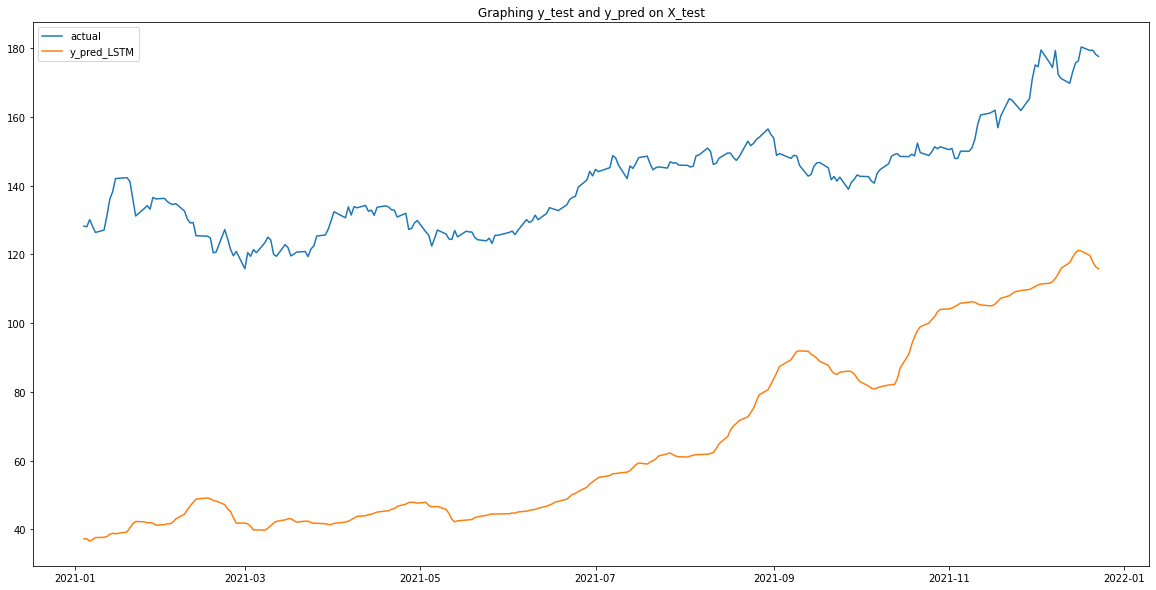

In [47]:
plt.figure(figsize=(20,10))
plt.plot(result.index, result['actual'], label='actual')
plt.plot(result.index, result['y_pred_LSTM'], label='y_pred_LSTM')
plt.legend()
plt.title("Graphing y_test and y_pred on X_test")
plt.show()

In [48]:
result

,actual,y_pred_LSTM
Date,,
2021-01-04,128.1897,37.2504
2021-01-05,128.0108,37.2442
2021-01-06,130.0880,36.5864
2021-01-07,128.1202,37.0197
2021-01-08,126.3610,37.6262
...,...,...
2021-12-17,180.3300,120.9687
2021-12-20,179.2900,119.6704
2021-12-21,179.3800,117.8744


In [24]:
y_train_pred = model.predict(X_train)

In [25]:
train_graph = y_train_df.copy()
y_train_df.rename(columns={'target':'y_train_actual'}, inplace=True)
y_train_df['y_train_pred'] = y_train_pred

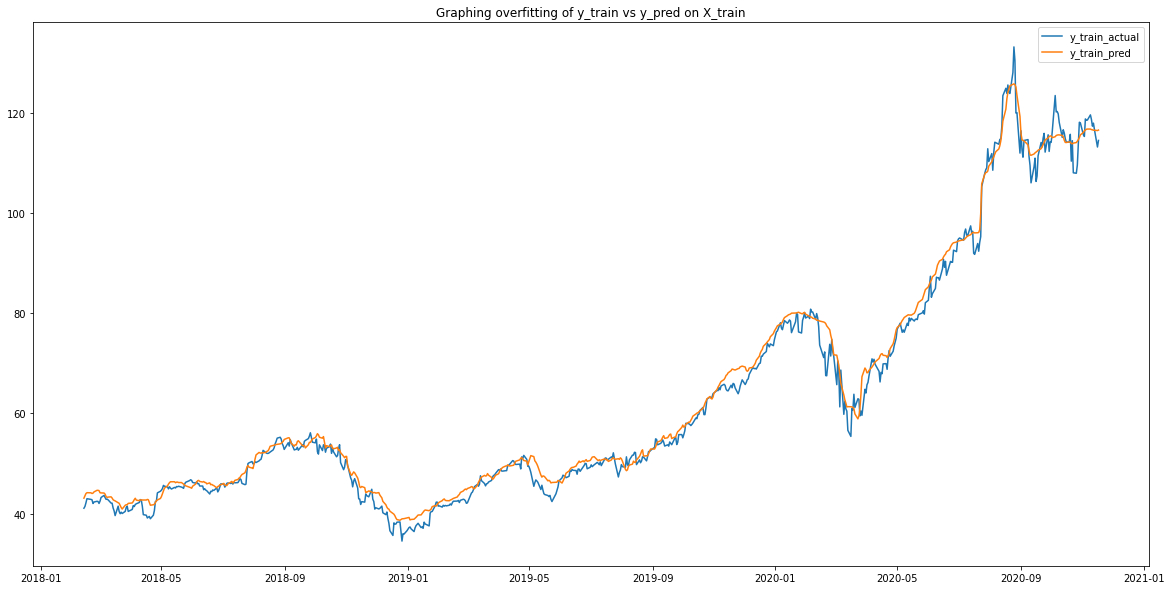

In [26]:
plt.figure(figsize=(20,10))
plt.plot(y_train_df.index, y_train_df['y_train_actual'], label='y_train_actual')
plt.plot(y_train_df.index, y_train_df['y_train_pred'], label='y_train_pred')
plt.legend()
plt.title("Graphing overfitting of y_train vs y_pred on X_train")
plt.show()

### Saving as pickle file

In [49]:
result.to_pickle('lstm_result.pickle')

In [71]:
result = pd.read_pickle('lstm_result.pickle')

In [72]:
result.to_csv("lstm_pred.csv")

In [69]:
result.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 247 entries, 2021-01-04 to 2021-12-23
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   actual       247 non-null    float64
 1   y_pred_LSTM  247 non-null    float32
dtypes: float32(1), float64(1)
memory usage: 4.8 KB


### Saving model as joblib

In [52]:
joblib.dump(model, 'lstm.joblib')

2022-01-18 21:43:29.004537: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://86de2ced-e893-4e6f-b5f3-ff081972d9ff/assets


INFO:tensorflow:Assets written to: ram://86de2ced-e893-4e6f-b5f3-ff081972d9ff/assets


['lstm.joblib']

In [9]:
loaded = joblib.load("lstm.joblib")

In [10]:
test = loaded.predict(X_train)

In [55]:
test

array([[ 42.369827],
       [ 42.596184],
       [ 42.799812],
       [ 42.858547],
       [ 42.834625],
       [ 42.764095],
       [ 42.829063],
       [ 42.99472 ],
       [ 43.169807],
       [ 43.156105],
       [ 43.120205],
       [ 42.85864 ],
       [ 42.914963],
       [ 43.03759 ],
       [ 43.107193],
       [ 43.012127],
       [ 43.121403],
       [ 43.2851  ],
       [ 43.418922],
       [ 43.375576],
       [ 43.260162],
       [ 43.272842],
       [ 43.16556 ],
       [ 42.885067],
       [ 42.831383],
       [ 42.516296],
       [ 42.092125],
       [ 41.730156],
       [ 42.066845],
       [ 41.93766 ],
       [ 41.75609 ],
       [ 41.81923 ],
       [ 41.683838],
       [ 41.796486],
       [ 41.948654],
       [ 42.10248 ],
       [ 41.81929 ],
       [ 41.75695 ],
       [ 41.860565],
       [ 41.872623],
       [ 41.9688  ],
       [ 42.036724],
       [ 42.1549  ],
       [ 42.338676],
       [ 42.45685 ],
       [ 42.227425],
       [ 41.73785 ],
       [ 41.8

### Original LSTM graph without 

In [ ]:
df = pd.read_pickle('lstm_result.pickle')

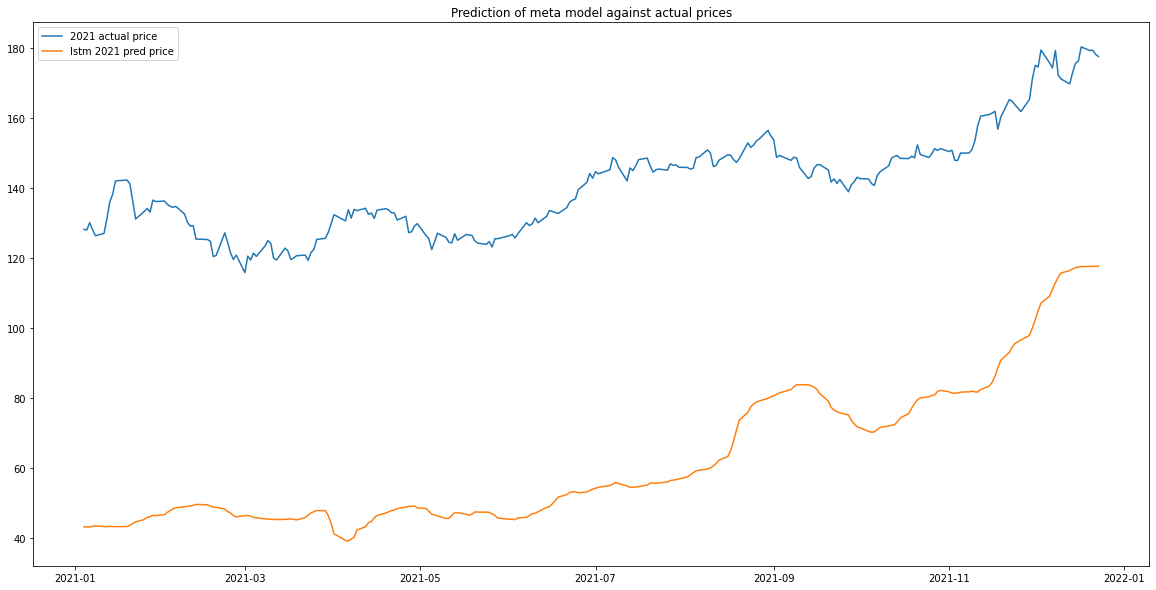

In [123]:
plt.figure(figsize=(20,10))
plt.plot(df.index, df['y_actual'], label='2021 actual price')
plt.plot(df.index, df['y_pred'], label='lstm 2021 pred price')
plt.legend()
plt.title('Prediction of meta model against actual prices')
plt.show()

In [122]:
df.columns

Index(['y_actual', 'y_pred'], dtype='object')

### Stacked metamodel - Linear Regression

In [56]:
model = joblib.load("lstm.joblib")
df = pd.read_pickle('lstm_result.pickle')

In [57]:
df.rename(columns={'y_pred_LSTM':'y_pred', 'actual':'y_actual'}, inplace=True)

In [58]:
df.columns

Index(['y_actual', 'y_pred'], dtype='object')

In [59]:
from sklearn.linear_model import LinearRegression

In [60]:
tlength = int(len(df)*0.8)
X_train = pd.DataFrame(df.iloc[0:tlength,1]); X_test = pd.DataFrame(df.iloc[tlength:-1,1])
y_train = df.iloc[0:tlength,0]; y_test = df.iloc[tlength:-1,0]

In [61]:
metamodel = LinearRegression()
metamodel.fit(X_train, y_train)

LinearRegression()

In [8]:
joblib.dump(metamodel, 'linreg.joblib')

['linreg.joblib']

In [62]:
metamodel.score(X_test, y_test)
#linear regression score of r2 from -1 to 1

0.4159670601796511

In [63]:
y_pred = metamodel.predict(X_test)

In [64]:
results = X_test.copy()
results.rename(columns={'y_pred':'meta_X_test'}, inplace=True)
results['meta_y_test'] = y_test
results['meta_y_pred'] = y_pred

In [65]:
y_test

Date
2021-10-14   149.2621
2021-10-15   148.4733
2021-10-18   148.4234
2021-10-19   149.1024
2021-10-20   148.6331
2021-10-21   152.3477
2021-10-22   149.5817
2021-10-25   148.7429
2021-10-26   149.8014
2021-10-27   151.2692
2021-10-28   150.7400
2021-10-29   151.2800
2021-11-01   150.4400
2021-11-02   150.8100
2021-11-03   147.9200
2021-11-04   147.8700
2021-11-05   149.9900
2021-11-08   150.0000
2021-11-09   151.0000
2021-11-10   153.4900
2021-11-11   157.8700
2021-11-12   160.5500
2021-11-15   161.0200
2021-11-16   161.4100
2021-11-17   161.9400
2021-11-18   156.8100
2021-11-19   160.2400
2021-11-22   165.3000
2021-11-23   164.7700
2021-11-24   163.7600
2021-11-26   161.8400
2021-11-29   165.3200
2021-11-30   171.1800
2021-12-01   175.0800
2021-12-02   174.5600
2021-12-03   179.4500
2021-12-06   175.7400
2021-12-07   174.3300
2021-12-08   179.3000
2021-12-09   172.2600
2021-12-10   171.1400
2021-12-13   169.7500
2021-12-14   172.9900
2021-12-15   175.6400
2021-12-16   176.2800
2021-

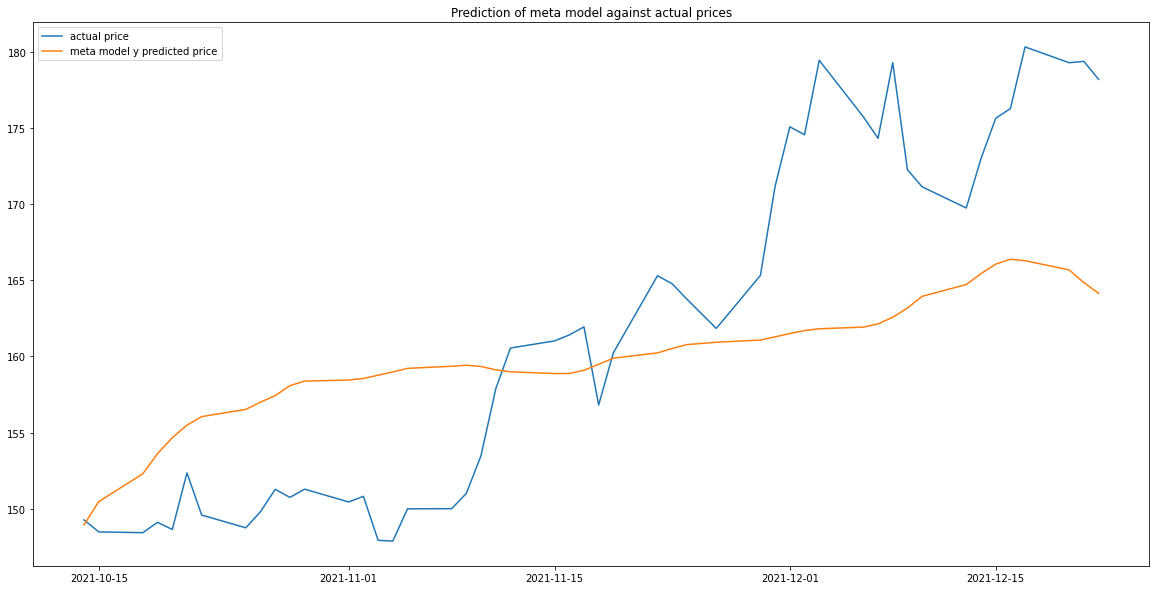

In [66]:
plt.figure(figsize=(20,10))
plt.plot(results.index, results['meta_y_test'], label='actual price')
plt.plot(results.index, results['meta_y_pred'], label='meta model y predicted price')
plt.legend()
plt.title('Prediction of meta model against actual prices')
plt.show()

In [67]:
results['error'] = results['meta_y_pred'] - results['meta_y_test']
print(f"MSE: {(results['error']**2).mean()}") #mean of squared error
print(f"MAE: {(results['error'].abs()).mean()}") #mean of squared error

MSE: 75.54608922499251
MAE: 7.439603221659758


In [14]:
np.abs(results['error']).mean()

3.771956151845504

In [16]:
from scipy.stats import pearsonr

In [36]:
x=results['meta_y_pred']
y=results['meta_y_test']

In [37]:
for i in range(1,20):
    new_y = y.shift(i)
    print(f"shift {i}: {pearsonr(x[i:],new_y[i:])[0]}")

# print(f"shift 0: {pearsonr(x[1:],y[1:])[0]}")
# print(f"shift 1: {pearsonr(x1[1:],y[1:])[0]}")
# print(f"shift 2: {pearsonr(x2[2:],y[2:])[0]}")
# print(f"shift 3: {pearsonr(x3[3:],y[3:])[0]}")
# print(f"shift 4: {pearsonr(x4[4:],y[4:])[0]}")

shift 1: 0.9498698328924331
shift 2: 0.9560312115706031
shift 3: 0.9616767573930413
shift 4: 0.9674311630179064
shift 5: 0.9708245708795502
shift 6: 0.9692478950486533
shift 7: 0.9621149842476001
shift 8: 0.9517985325226949
shift 9: 0.9365067986279118
shift 10: 0.9186436895018331
shift 11: 0.9059904379839371
shift 12: 0.8878440284303815
shift 13: 0.871497614664774
shift 14: 0.8703010329666176
shift 15: 0.8603226403089783
shift 16: 0.862494238979296
shift 17: 0.8549070670556729
shift 18: 0.8262482556523428
shift 19: 0.7896736118182668


Above pearson's correlation efficient at least shows that the predicted x compared to y-n_days has high correlation (approx.0.94-0.97) for 8 continuous days, so the model is likely predicting largely based on the prices from the past 8 days, and not just 1 day

In [26]:
x1[0:5]

Date
2021-10-14        NaN
2021-10-15   149.2621
2021-10-18   148.4733
2021-10-19   148.4234
2021-10-20   149.1024
Name: meta_y_test, dtype: float64

In [15]:
results

,meta_X_test,meta_y_test,meta_y_pred,error
Date,,,,
2021-10-14,73.1819,149.2621,146.7274,-2.5348
2021-10-15,74.2597,148.4733,147.3792,-1.0941
2021-10-18,75.5411,148.4234,148.1542,-0.2692
2021-10-19,77.0826,149.1024,149.0864,-0.0160
2021-10-20,78.4046,148.6331,149.8859,1.2528
2021-10-21,79.4494,152.3477,150.5178,-1.8299
2021-10-22,80.0153,149.5817,150.8600,1.2783
2021-10-25,80.3260,148.7429,151.0479,2.3050
2021-10-26,80.6967,149.8014,151.2721,1.4707


## Testing

In [91]:
params={
    'hist_days':45, 'fut_days':2,
    'time_start':dt.datetime(2014,9,1,0,0,0), 'time_end':dt.datetime(2020,12,31,0,0,0),
    'days_list':[14,50,200], 'bol_days':45, 'rsi_days':45, 'ma_days': 45,
    'val_size': 0.2, 'test_size':0.2, 'batch_size':2, 'epochs':20,
    'loss':'mae', 'optimizer':'rmsprop', 'metrics':'mae', 'patience':10,
    'train_loss': np.nan, 'val_loss':np.nan, 'test_loss':np.nan, 'test_metric':np.nan,
    'last_px':np.nan, 'remarks':''
    }
df = load_data(params)

right


In [103]:
see = dt.datetime(2020,1,1,0,0,0)
print("{0:0=2d}".format(see.month))
month = "{0:0=2d}".format(see.month)
type(month)

01


str

In [15]:
params={
    'hist_days':30, 'fut_days':5,
    'time_start':dt.datetime(2017,9,1,0,0,0), 'time_end':dt.datetime(2020,12,31,0,0,0),
    'bol_days':30, 'rsi_days':30, 'ma_days': 30,
    'val_size': 0.2, 'test_size':0.2, 'batch_size':4, 'epochs':50,
    'loss':'mae', 'optimizer':'rmsprop', 'metrics':'mae', 'patience':10,
    'train_loss': np.nan, 'val_loss':np.nan, 'test_loss':np.nan, 'test_metric':np.nan,
    'last_px':np.nan, 'remarks':''
    }
df = load_data()
df = make_features_target(df, params)
X = df.drop(labels='target', axis=1).copy()
y = df[['target']].copy()

In [16]:
from sklearn.model_selection import TimeSeriesSplit
X

,Adj Close,w_bol,rsi,vix_adj_close,ma,obv
Date,,,,,,
2017-09-01,39.084606,11.509386,63.108697,10.13,37.490514,3105968000
2017-09-05,38.615261,11.334846,60.019660,12.23,37.574575,2988094000
2017-09-06,38.574757,11.153952,59.758524,11.63,37.652144,2901487200
2017-09-07,38.419895,10.953333,58.747578,11.55,37.718856,2813773200
2017-09-08,37.793308,10.210811,54.862793,12.12,37.787622,2699327200
...,...,...,...,...,...,...
2020-12-16,127.026901,11.768031,59.309264,22.50,119.295469,6091306100
2020-12-17,127.911446,12.345348,59.970969,21.93,119.757552,6185665900
2020-12-18,125.883957,12.801435,57.744377,21.57,120.017119,5993124400


## RNN - Initial Setup

### Getting data
Data is downloaded for the first time and stored in the same folder as this jupyter notebook. Comment/uncomment to execute accordingly<br>
Note: Close data is not the same Adj Close data

In [2]:
#Downloading from yfinance
# df=yf.download('AAPL','2018-01-01','2020-12-31')
#Saving file to jupyter notebook folder
# df.to_csv("/Users/ivanlimsweeyong/code/ivanlimsy/jupyter/AAPL.csv")
#Retrieving file from jupyter notebook folder
df = pd.read_csv("/Users/ivanlimsweeyong/code/ivanlimsy/jupyter/AAPL.csv", index_col=0)
df.index = pd.to_datetime(df.index, format='%Y-%m-%d')

### Prepare technical indicators

In [3]:
import ta

####  Volatility - Bollinger Bands 20 days, 2 s.d. (width)

In [4]:
bol = ta.volatility.BollingerBands(df['Adj Close'], window=30, window_dev=2)
df['w_bol'] = bol.bollinger_wband()

#### Momentum - RSI 14 days

In [5]:
rsi = ta.momentum.RSIIndicator(df['Adj Close'], window=14)
df['rsi'] = rsi.rsi()

#### VIX index

In [6]:
#Downloading from yfinance
# vix_df=yf.download('^VIX','2018-01-01','2020-12-31')
#Saving file to jupyter notebook folder
# vix_df.to_csv("/Users/ivanlimsweeyong/code/ivanlimsy/jupyter/VIX.csv")
#Retrieving file from jupyter notebook folder
vix_df = pd.read_csv("/Users/ivanlimsweeyong/code/ivanlimsy/jupyter/VIX.csv", index_col=0)
vix_df.index = pd.to_datetime(vix_df.index, format='%Y-%m-%d')
vix_df.rename(columns={'Adj Close': 'vix_adj_close'}, inplace=True)
df = df.merge(vix_df[['vix_adj_close']], left_index=True, right_index=True)

#### Simple Moving Average

In [7]:
ma = ta.trend.SMAIndicator(df['Adj Close'], window=30)
df['ma_30'] = ma.sma_indicator()

#### On Balance Volume

In [8]:
obv = ta.volume.OnBalanceVolumeIndicator(df['Adj Close'], df['Volume'])

In [9]:
df['obv'] = obv.on_balance_volume()

#### Visualization of indicators

In [68]:
df2 = df.dropna(axis=0).copy()   #so as not to drop inplace

In [75]:
df2.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'h_bol', 'l_bol',
       'rsi', 'vix_adj_close', 'ma_30', 'obv', 'w_bol'],
      dtype='object')

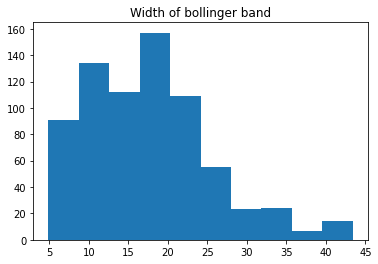

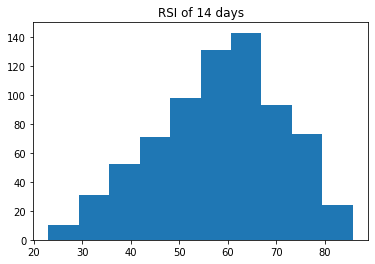

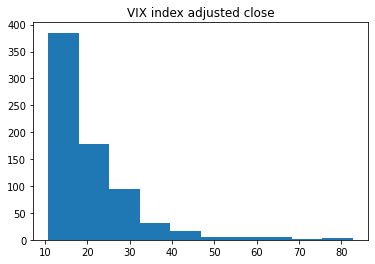

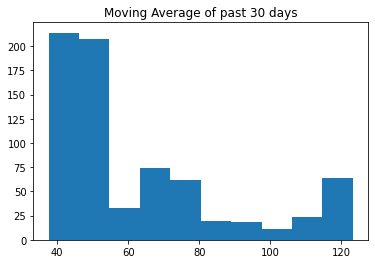

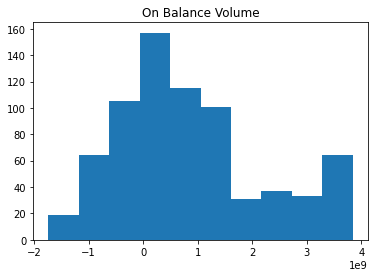

In [78]:
fig = plt.figure()
fig = plt.hist(df2['w_bol'])
plt.title("Width of bollinger band")
plt.show()
fig = plt.figure()
fig = plt.hist(df2['rsi'])
plt.title("RSI of 14 days")
plt.show()
fig = plt.figure()
fig = plt.hist(df2['vix_adj_close'])
plt.title("VIX index adjusted close")
plt.show()
fig = plt.figure()
fig = plt.hist(df2['ma_30'])
plt.title("Moving Average of past 30 days")
plt.show()
fig = plt.figure()
fig = plt.hist(df2['obv'])
plt.title("On Balance Volume")
plt.show()

### Prepare X and y data

X.shape = (n_sequences, n_observations, n_features)<br>
sequences: sequence of 30 consecutive observations of the selected features<br>
observations: a single day of selected features' values<br>
features: price and indicators

In [12]:
df2 = df.dropna(axis=0).copy()
df2.drop(labels=['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
#Tried using .iloc but not sure how to split into sequences of 30 days
# X = df2.iloc[:-5,:]
# X.drop(labels=['Adj Close'], axis=1, inplace=True)
# y = df2.iloc[5:,:][['Adj Close']]
X=[]; y=[]
for i in range(len(df2)-35):
    X.append(np.array(df2.iloc[i:(i+30),1:6]))
    y.append(np.array(df2.iloc[(i+35):(i+36),0]))
X = np.array(X)
y = np.array(y)
print(X.shape)   #(n_sequences, n_observations, n_features)
print(y.shape)

(691, 30, 5)
(691, 1)


Checkpoint: created X of 6 features:
- adj close price
- width of bollinger bands
- rsi
- vix adj close price
- ma 30 days
- on balance volume

Pointers:
- No. of rnn units refers to n number of interesting temporal features from the time series (random, unknown, selected by model)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Normalization, Dense, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape); print(X_test.shape); print(y_train.shape); print(y_test.shape)

(552, 30, 5)
(139, 30, 5)
(552, 1)
(139, 1)


In [17]:
def initialize_model():
    model=Sequential()
#     model.add(Normalization())
    model.add(SimpleRNN(units=30, activation='tanh', input_shape=(30,5)))
    model.add(Dense(15,activation="linear"))
    model.add(Dense(1,activation="linear"))
    model.compile(loss='mae', optimizer='rmsprop')
    return model

In [18]:
model = initialize_model()
es = EarlyStopping(patience=5)
history = model.fit(X_train, y_train,
                    batch_size=2, verbose=1,
                    epochs= 20, validation_split=0.2)

Epoch 1/20
221/221 [==============================] - 4s 11ms/step - loss: 58.0522 - val_loss: 45.2376
Epoch 2/20
221/221 [==============================] - 2s 8ms/step - loss: 41.5412 - val_loss: 37.7771
Epoch 3/20
221/221 [==============================] - 2s 9ms/step - loss: 39.5598 - val_loss: 37.2128
Epoch 4/20
221/221 [==============================] - 2s 8ms/step - loss: 38.9664 - val_loss: 36.4987
Epoch 5/20
221/221 [==============================] - 2s 8ms/step - loss: 38.3890 - val_loss: 36.0008
Epoch 6/20
221/221 [==============================] - 2s 8ms/step - loss: 37.7615 - val_loss: 35.1918
Epoch 7/20
221/221 [==============================] - 2s 9ms/step - loss: 37.0922 - val_loss: 34.4979
Epoch 8/20
221/221 [==============================] - 4s 16ms/step - loss: 36.3846 - val_loss: 33.7859
Epoch 9/20
221/221 [==============================] - 4s 16ms/step - loss: 35.6474 - val_loss: 32.9253
Epoch 10/20
221/221 [==============================] - 3s 14ms/step - loss: 34.

In [19]:
#Tanh
result = model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 4ms/step - loss: 17.8817


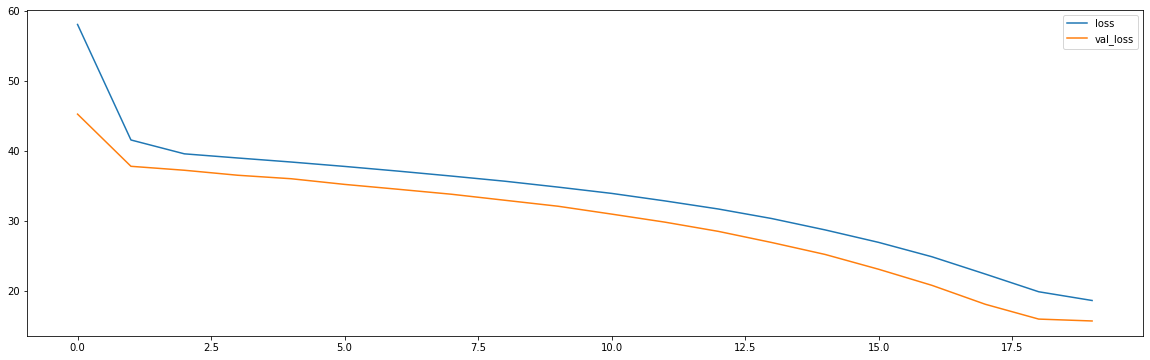

In [28]:
plt.figure(figsize=(20,6))
plt.plot([i for i in range(0,20)], history.history['loss'], label='loss')
plt.plot([i for i in range(0,20)], history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

## yFinance API

### Installations, importing

In [1]:
!pip install yfinance

  Preparing metadata (setup.py) ... done
  Created wheel for multitasking: filename=multitasking-0.0.10-py3-none-any.whl size=8489 sha256=5e36f4c637dc8e80eb25b5b825b499227ed8abbcf47ec9e8cb148076692eeef3
  Stored in directory: /Users/ivanlimsweeyong/Library/Caches/pip/wheels/21/c9/66/b41c847de65c7985db52ec21d59996841598b8b0e93f2b9500
Successfully built multitasking


In [4]:
import yfinance as yf

### Downloading data

Data consists of open/high/low/close/volume and also adjusted close - adjusted close accounts for all applicable splits and dividend distributions

In [104]:
data=yf.download('AAPL','2015-01-01','2021-12-01')
df = data.copy()

[*********************100%***********************]  1 of 1 completed


In [21]:
df['close_equals_adjclose'] = (df['Close']==df['Adj Close'])
df['close_notequal_adjclose'] = df['close_equals_adjclose'].map({True:1,False:0.5})

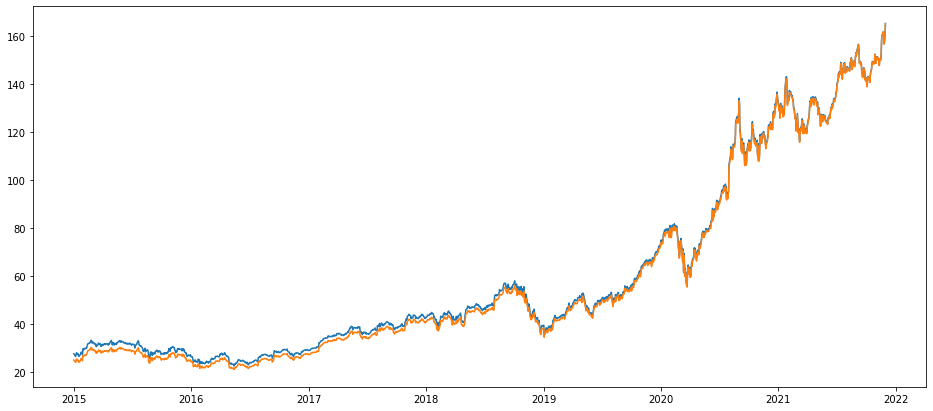

In [17]:
fig = plt.figure(figsize=(16,7))
plt.plot(df.index, df['Close'])
plt.plot(df.index, df['Adj Close'])
plt.show()

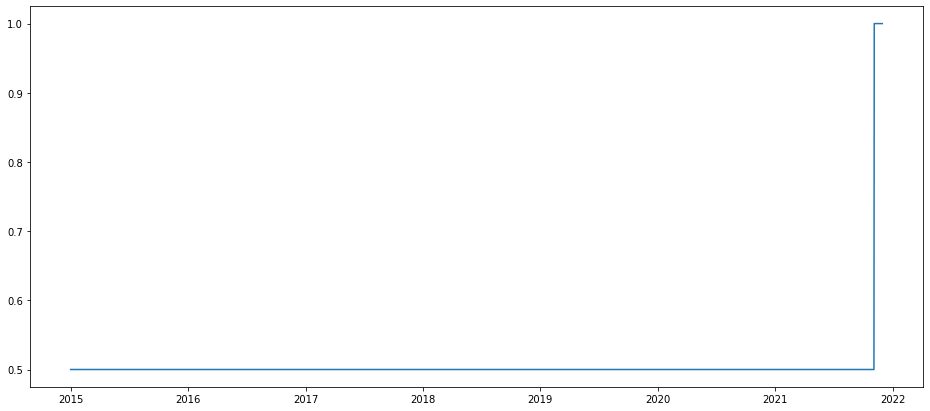

In [22]:
fig = plt.figure(figsize=(16,7))
plt.plot(df.index, df['close_notequal_adjclose'])
plt.show()

In [72]:
df

,Open,High,Low,Close,Adj Close,Volume,close_equals_adj_close,close_equals_adjclose,close_notequal_adjclose
Date,,,,,,,,,
2014-12-31,28.205000,28.282499,27.552500,27.594999,24.983654,165613600,False,False,0.5
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.745995,212818400,False,False,0.5
2015-01-05,27.072500,27.162500,26.352501,26.562500,24.048864,257142000,False,False,0.5
2015-01-06,26.635000,26.857500,26.157499,26.565001,24.051126,263188400,False,False,0.5
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.388376,160423600,False,False,0.5
...,...,...,...,...,...,...,...,...,...
2021-11-23,161.119995,161.800003,159.059998,161.410004,161.410004,96041900,True,True,1.0
2021-11-24,160.750000,162.139999,159.639999,161.940002,161.940002,69463600,True,True,1.0
2021-11-26,159.570007,160.449997,156.360001,156.809998,156.809998,76959800,True,True,1.0


### Function to quicksearch different stocks

In [2]:
tech_stocks = ['AAPL', 'GOOG', 'MSFT', 'FB', 'AMZN']
indices = ['^DJI', '^IXIC', '^N225', '^HSI', '^FTSE']

In [5]:
def see_plots(stock, dates):
    data=yf.download(stock,dates[0],dates[1])
    df = data.copy()
    date_change_sr = (df['Close']!=df['Adj Close']); date_change = None
    if date_change_sr.empty == False:   #there was a date change
        date_change = date_change_sr.index[0]
    #Plotting
    fig, ax = plt.subplots(1,2, figsize=(16,4))
    ax[0].plot(df.index, df['Close']); ax[0].plot(df.index, df['Adj Close'])
    ax[0].plot(df.index, df['High']); ax[0].plot(df.index, df['Low'])
    ax[0].set_title(f"Stock price for {stock}")
    plt.show()
    if date_change==None: print(f"Stock price for {stock}, close diverged on {date_change}")

[*********************100%***********************]  5 of 5 completed


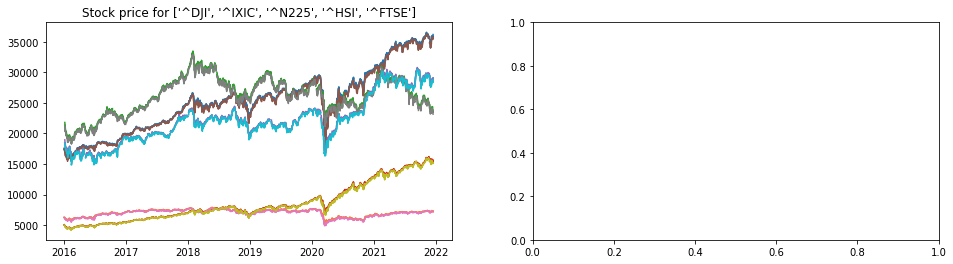

[*********************100%***********************]  5 of 5 completed


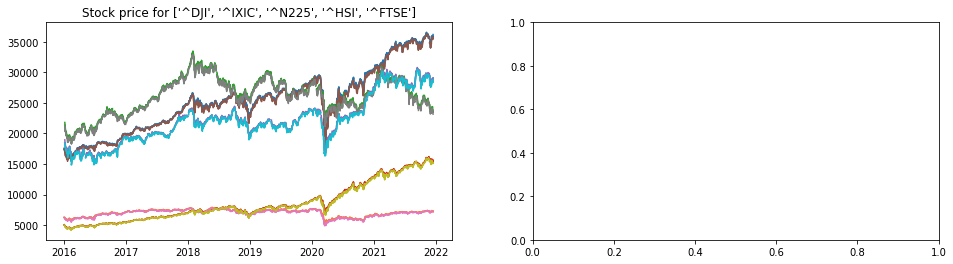

[*********************100%***********************]  5 of 5 completed


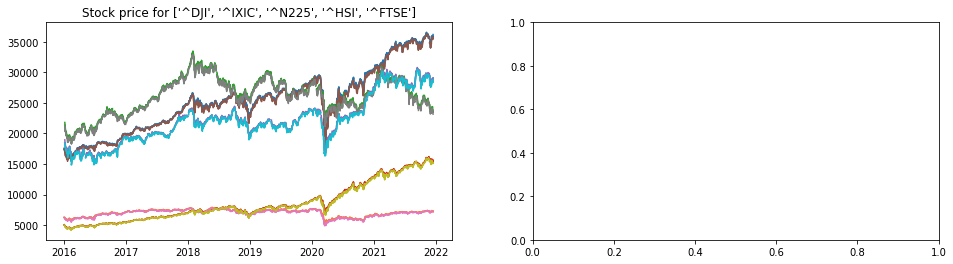

[*********************100%***********************]  5 of 5 completed


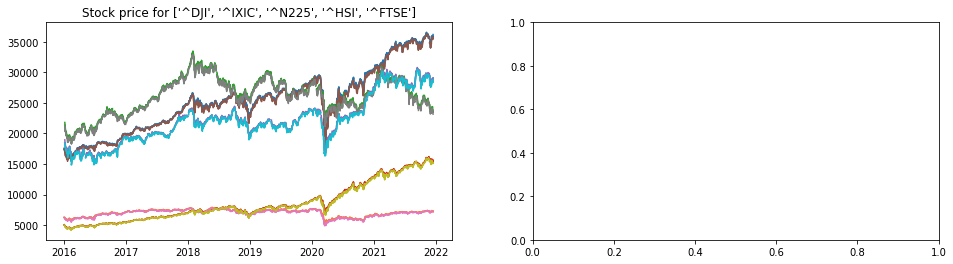

[*********************100%***********************]  5 of 5 completed


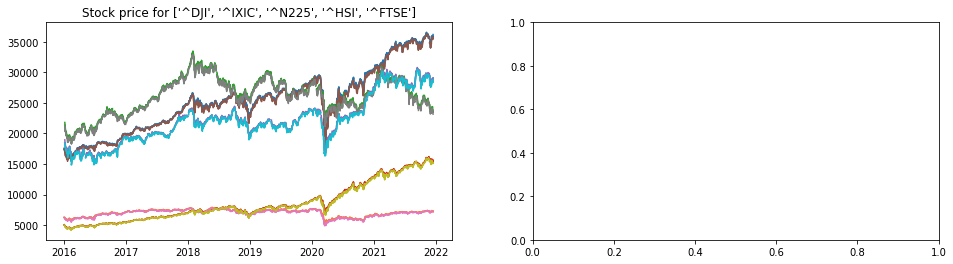

In [7]:
dates = ['2016-01-01', '2021-12-17']
for asset in tech_stocks:
    see_plots(indices, dates)

[*********************100%***********************]  1 of 1 completed


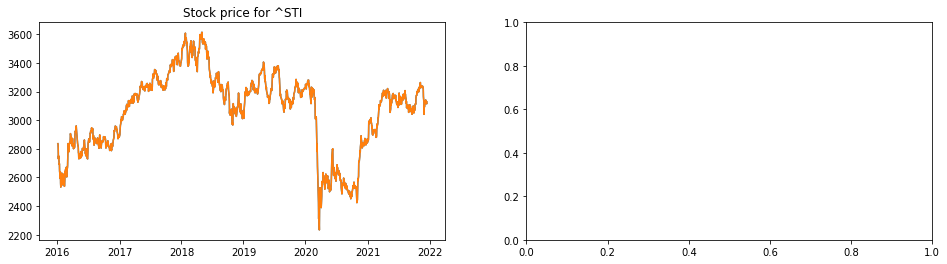

In [131]:
#For single checking of plots
temp_dates = ['2016-01-01', '2021-12-17']
see_plots("^STI", temp_dates)

In [139]:
#For accessing dataframes
data=yf.download('DJI',temp_dates[0],temp_dates[1])

[*********************100%***********************]  1 of 1 completed


### Stationarity Tests

In [138]:
from statsmodels.tsa.stattools import adfuller

In [146]:
temp_dates = ['2019-01-01', '2019-12-31']
data=yf.download('DJI',temp_dates[0],temp_dates[1])
adfuller(data['Close'])

[*********************100%***********************]  1 of 1 completed


(-2.516157594989495,
 0.11159233909220129,
 0,
 104,
 {'1%': -3.4948504603223145,
  '5%': -2.889758398668639,
  '10%': -2.5818220155325444},
 1218.5472454177066)

In [7]:
import ta #https://github.com/bukosabino/ta

## Oanda API

In [147]:
# account = 
# token = 
headers = {'Authorization':f'Bearer {token}', 'Content-Type':'application/json'}

instrument= 'EUR_USD'
end_datetime = str(dt.datetime(2014,5,13,0,0,0)).replace(' ','T')
params = {'price':'M', 'granularity': 'M1',
          'count': 5000, 'to': end_datetime}

url = f'https://api-fxpractice.oanda.com/v3/accounts/{account}/instruments/{instrument}/candles'
response = requests.get(url, headers=headers, params=params).json()
# df = pd.DataFrame(response['candles'])


NameError: name 'token' is not defined

In [24]:
pd.DataFrame(response['candles'])

,complete,volume,time,mid
0,True,43,2014-05-07T15:14:00.000000000Z,"{'o': '1.39210', 'h': '1.39217', 'l': '1.39187..."
1,True,38,2014-05-07T15:15:00.000000000Z,"{'o': '1.39188', 'h': '1.39189', 'l': '1.39179..."
2,True,31,2014-05-07T15:16:00.000000000Z,"{'o': '1.39186', 'h': '1.39197', 'l': '1.39186..."
3,True,117,2014-05-07T15:17:00.000000000Z,"{'o': '1.39197', 'h': '1.39218', 'l': '1.39190..."
4,True,51,2014-05-07T15:18:00.000000000Z,"{'o': '1.39217', 'h': '1.39229', 'l': '1.39214..."
...,...,...,...,...
4995,True,8,2014-05-13T03:55:00.000000000Z,"{'o': '1.37573', 'h': '1.37575', 'l': '1.37573..."
4996,True,8,2014-05-13T03:56:00.000000000Z,"{'o': '1.37573', 'h': '1.37575', 'l': '1.37573..."
4997,True,1,2014-05-13T03:57:00.000000000Z,"{'o': '1.37572', 'h': '1.37572', 'l': '1.37572..."
4998,True,5,2014-05-13T03:58:00.000000000Z,"{'o': '1.37573', 'h': '1.37574', 'l': '1.37571..."


In [5]:
end_datetime.replace(' ','T')

'2020-05-13T00:00:00'

## Others

In [3]:
#Downloading from yfinance
df=yf.download('^VIX','2016-01-01','2021-12-20')
#Saving file to jupyter notebook folder
# vix_df.to_csv("/Users/ivanlimsweeyong/code/ivanlimsy/jupyter/VIX.csv")
#Retrieving file from jupyter notebook folder
# vix_df = pd.read_csv("/Users/ivanlimsweeyong/code/ivanlimsy/jupyter/VIX.csv", index_col=0)
df.index = pd.to_datetime(vix_df.index, format='%Y-%m-%d')
# vix_df.rename(columns={'Adj Close': 'vix_adj_close'}, inplace=True)
# df = df.merge(vix_df[['vix_adj_close']], left_index=True, right_index=True)

[*********************100%***********************]  1 of 1 completed


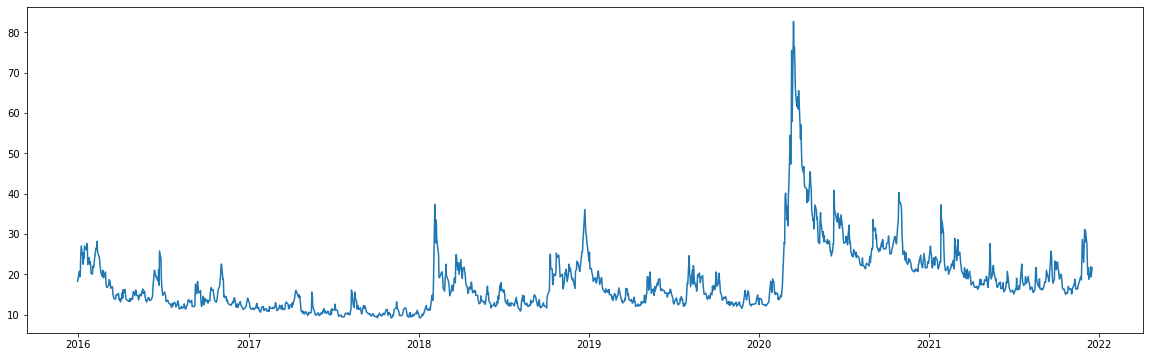

In [5]:
plt.figure(figsize=(20,6))
plt.plot(df.index, df['Adj Close'])
plt.show()